In [143]:
import numpy as np
import cv2
import glob 
import matplotlib.pyplot as plt
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline 

## Camera Calibration

Loading images and looking for corners on chessboard:

In [2]:
objpoints = [] #3D points in real world
imgpoints = [] #2D points in image plane

nx = 9
ny = 6

#Prepare object points like (0, 0, 0), (1, 0, 0), ..., (nx-1, ny-1, 0)
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

#Load images
images_name = glob.glob('camera_cal/calibration*.jpg')

for filename in images_name:
    
    img = cv2.imread(filename)
    #Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #Look for chessboard and return if it was found and the corners
    found, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if found:
        #Append objp and corners 
        objpoints.append(objp)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(gray, (nx, ny), corners, found)     
        #plt.imshow(gray, cmap='gray')
        #plt.show()

Calibrating test image and undistorting it:

In [3]:
#Read test image
img = cv2.imread('camera_cal/test.jpg')

img_size = (img.shape[1], img.shape[0])

found, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,
                                                     img_size, None, None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg', dst)

#Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("camera_cal/wide_dist_pickle.p", "wb"))

Text(0.5,1,'Undistorted Image')

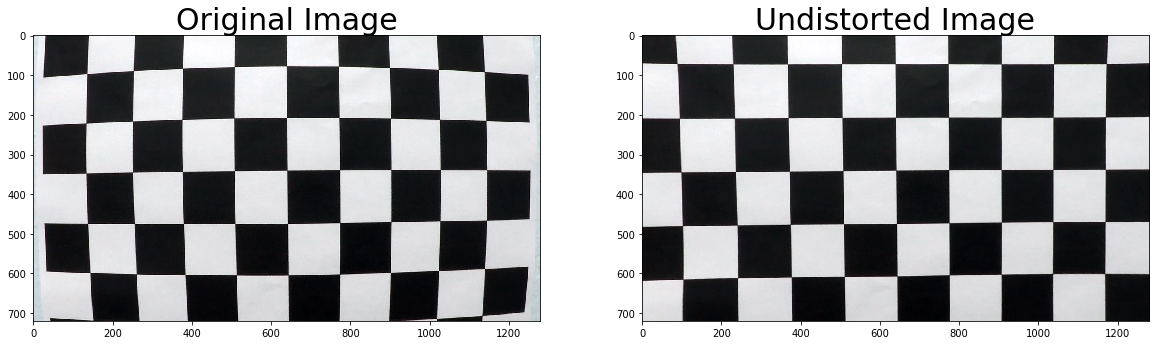

In [4]:
#Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)    

## Undistort test images

In [5]:
def undistort(image):
    
    img = np.copy(image)
    undistort_pickle = []   
    with (open("camera_cal/wide_dist_pickle.p", "rb")) as openfile:
        while True:
            try:
                undistort_pickle.append(pickle.load(openfile))
            except EOFError:
                break

    saved_dist = undistort_pickle[0]["dist"]
    saved_mtx = undistort_pickle[0]["mtx"]
   
    dst = cv2.undistort(img, saved_mtx, saved_dist, None, saved_mtx)
    
    return dst

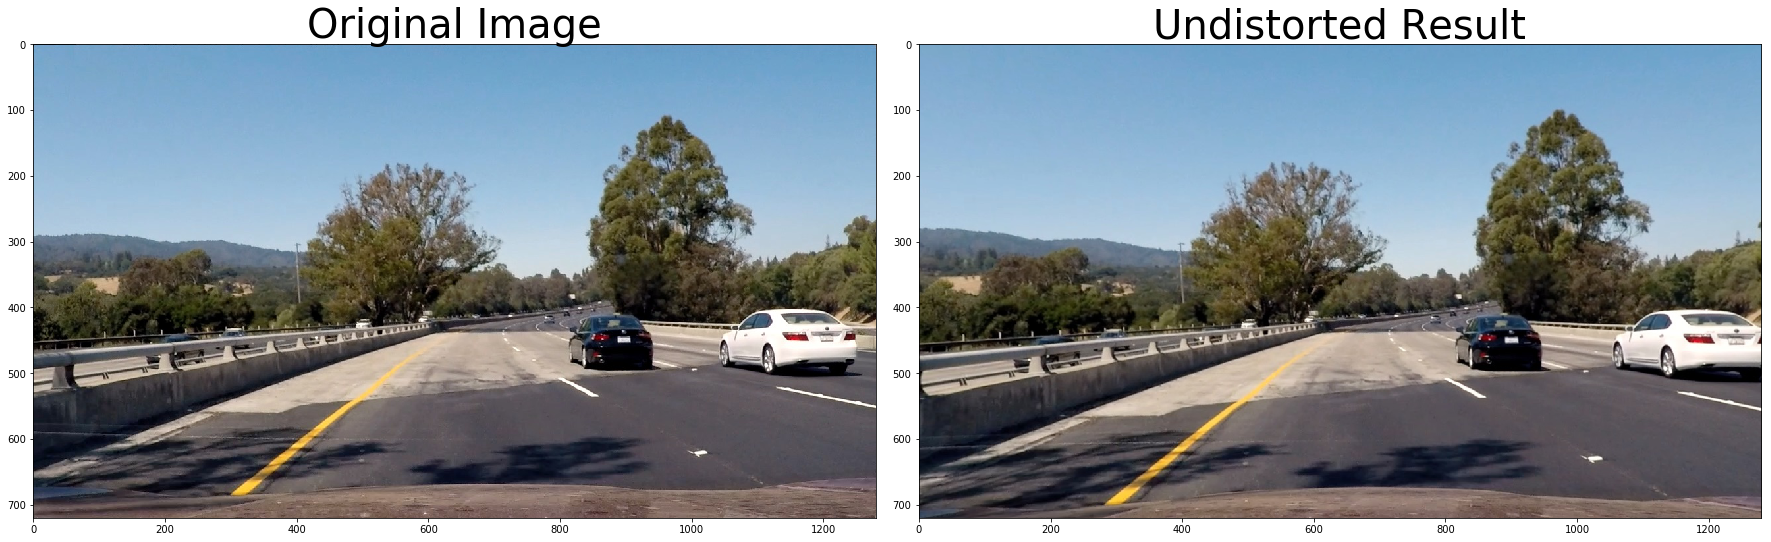

In [6]:
test_images_names = glob.glob('test_images/test*.jpg')

img = cv2.imread(test_images_names[0])

#Show undistortion
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted_image = undistort(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective Transform

In [7]:
def perspective(image):
    
    img = np.copy(image)
    img_size = (img.shape[1], img.shape[0])
    offset = 400
    #Define source points
    src = np.float32([[200, img_size[1]-50],
                      [img_size[0]//2-55, img_size[1]//2+90],
                      [img_size[0]//2+55, img_size[1]//2+90],
                      [img_size[0]-200, img_size[1]-50]])

    dst = np.float32([[offset, img_size[1]-1],
                      [offset, 0],
                      [img_size[0]-offset, 0],
                      [img_size[0]-offset, img_size[1]-1]])

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, src, dst

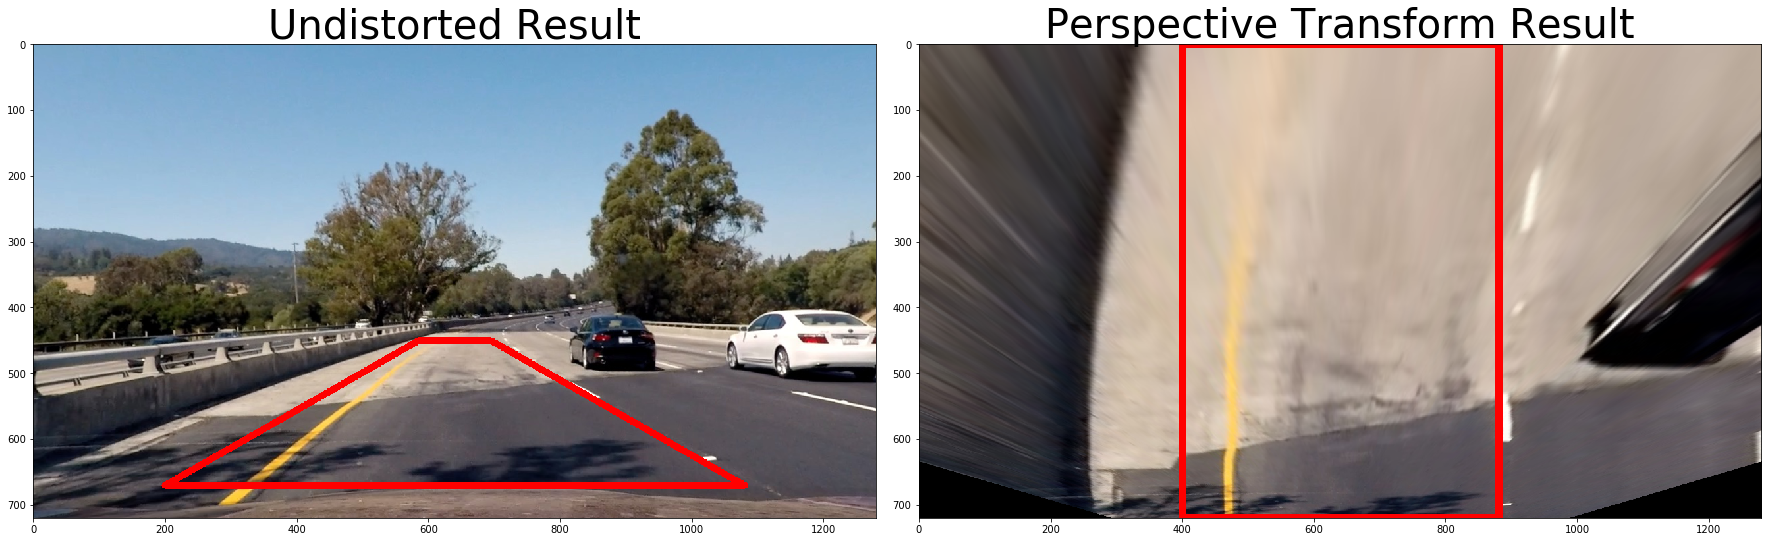

In [8]:
#straight_lines_img = undistort(cv2.imread('test_images/straight_lines2.jpg'))
#Show undistortion with perspective transformation
warped, M, src, dst = perspective(undistorted_image)

mask1 = np.copy(undistorted_image)
mask1 = cv2.polylines(mask1, [np.int32(src.reshape((-1, 1, 2)))], True, (255, 0, 0), lineType=8, thickness=10)
mask2 = np.copy(warped)
mask2 = cv2.polylines(mask2, [np.int32(dst.reshape((-1, 1, 2)))], True, (255, 0, 0), lineType=8, thickness=10)
    
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(mask1)
ax1.set_title('Undistorted Result', fontsize=40)
    
ax2.imshow(mask2)
ax2.set_title('Perspective Transform Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Color Pipeline

In [26]:
def color_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    area_of_interest = np.zeros_like(s_channel)
    area_of_interest[:, 300:980] = 1
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) | (sxbinary == 1)) & (area_of_interest == 1)] = 255
    
    return combined_binary

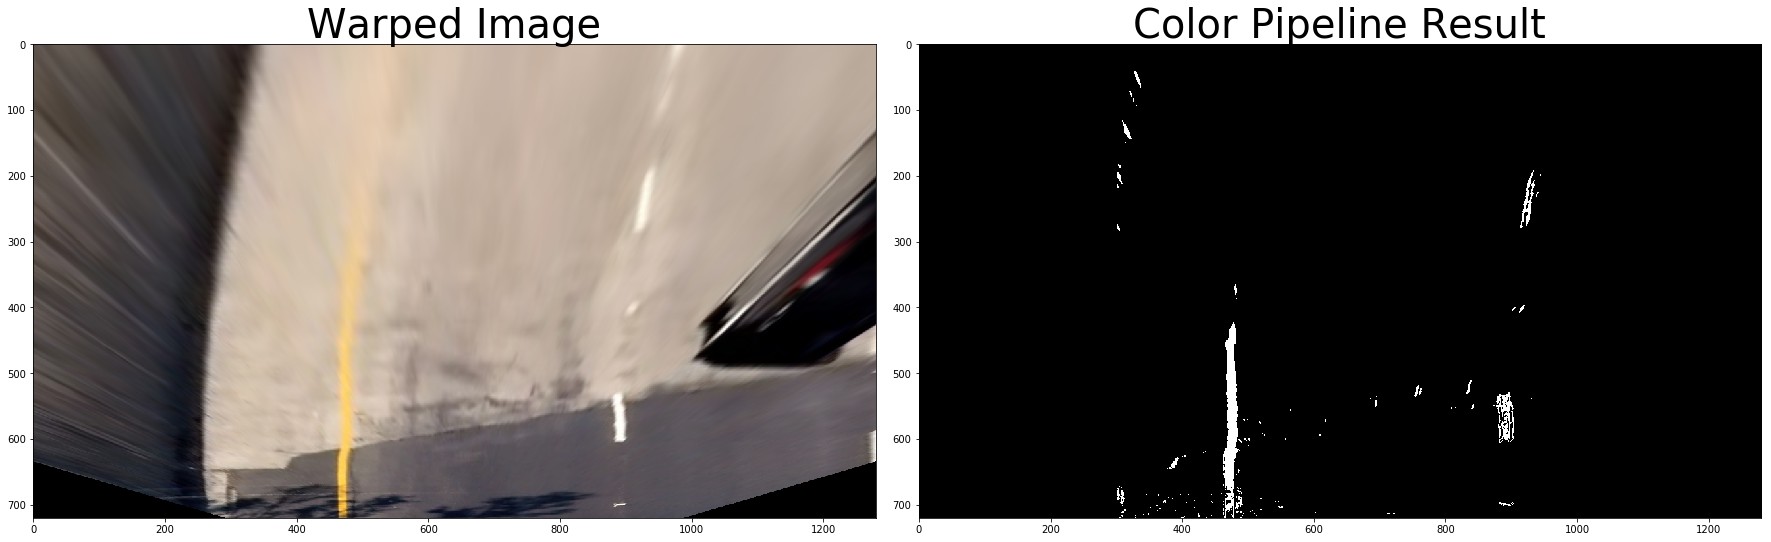

In [10]:
result = color_pipeline(warped, s_thresh=(200, 255), sx_thresh=(30, 100))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warped)
ax1.set_title('Warped Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Color Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Find lines

In [123]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
   

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window ###
        # `right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
        
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, visualize=False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit` ###
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
    ## Visualization ##
    if visualize:
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit

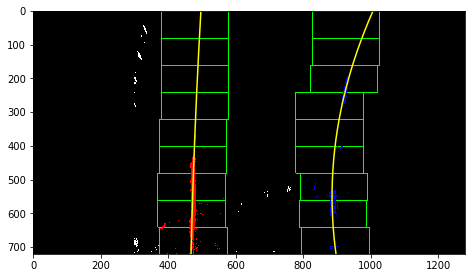

In [125]:
out_img, left_fitx, right_fitx, ploty, _, _ = fit_polynomial(result, True)

plt.imshow(out_img)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Measure Curvature and Vehicle Position

In [209]:
def measure_curvature_and_vehicle_position(ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty) * ym_per_pix
    #x= mx / (my ** 2) *a*(y**2)+(mx/my)*b*y+c
    
    left_fit_cr[0] *= xm_per_pix / (ym_per_pix**2)
    left_fit_cr[1] *= xm_per_pix / (ym_per_pix)
    right_fit_cr[0] *= xm_per_pix / (ym_per_pix**2)
    right_fit_cr[1] *= xm_per_pix / (ym_per_pix)
    
    # Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])  ## Implement the calculation of the right line here
    
    bottom_y = 669
    vehicle_center = 640
    
    l_fit_x_int = left_fit_cr[0]*bottom_y**2 + left_fit_cr[1]*bottom_y + left_fit_cr[2]
    r_fit_x_int = right_fit_cr[0]*bottom_y**2 + right_fit_cr[1]*bottom_y + right_fit_cr[2]
    
    lane_center_position = (r_fit_x_int + l_fit_x_int)/2
    vehicle_pos = (vehicle_center - lane_center_position) * xm_per_pix / 10
    
    return left_curverad, right_curverad, vehicle_pos

## Visualize Lane Lines

In [210]:
def plot_lane_lines(img, M, left_fitx, right_fitx, ploty, left_curverad, right_curverad, vehicle_pos):
    # Create an image to draw the lines on
    img_zero = np.zeros_like(img[:,:,1]).astype(np.uint8)
    color_warp = np.dstack((img_zero, img_zero, img_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = np.linalg.pinv(M)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    # Add curvature
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255,255,255)
    lineType = 2

    cv2.putText(result,"LANE CURVATURE:",
    (0, 50), 
    font, 
    1.5,
    fontColor,
    lineType)
    
    cv2.putText(result,"Left: %.2f m"%(left_curverad), 
    (0, 100), 
    font, 
    1,
    fontColor,
    lineType)
   
    cv2.putText(result,"Right: %.2f m"%(right_curverad), 
    (0, 135), 
    font, 
    1,
    fontColor,
    lineType)
    
    cv2.putText(result,"Vechicle Pos: %.2f m %s of center"%(abs(vehicle_pos), "left" if vehicle_pos < 0 else "right"), 
    (0, 170), 
    font, 
    1,
    fontColor,
    lineType)
    
    return result

## Pipeline on Test Images

In [211]:
def pipeline(image):
        
    pipeline_test = np.copy(image)
    pipeline_test = undistort(pipeline_test)
    pipeline_test, M, _, _ = perspective(pipeline_test)
    pipeline_test = color_pipeline(pipeline_test)
    out_img, left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial(pipeline_test)
    left_curverad, right_curverad, vehicle_pos = measure_curvature_and_vehicle_position(ploty, left_fit, 
                                                                                        right_fit)
    final = plot_lane_lines(image, M, left_fitx, right_fitx, ploty, left_curverad, right_curverad, vehicle_pos)
    
    return final

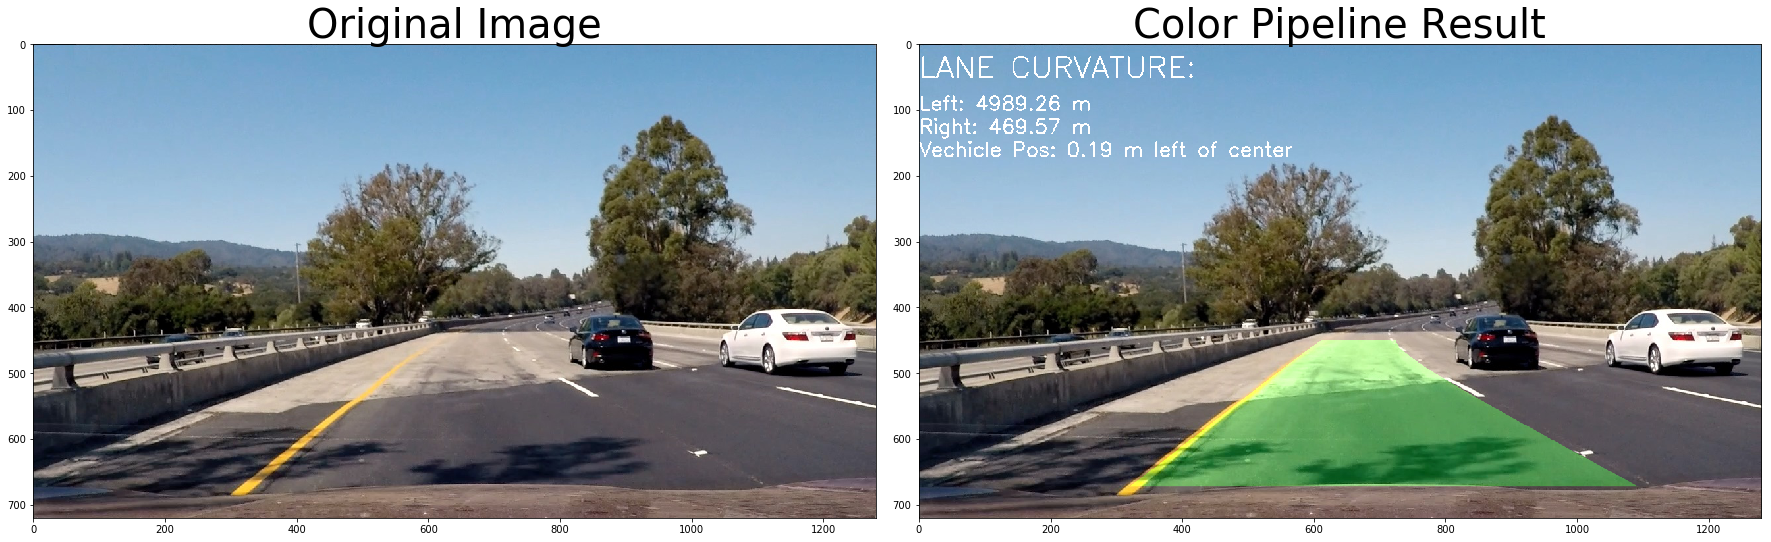

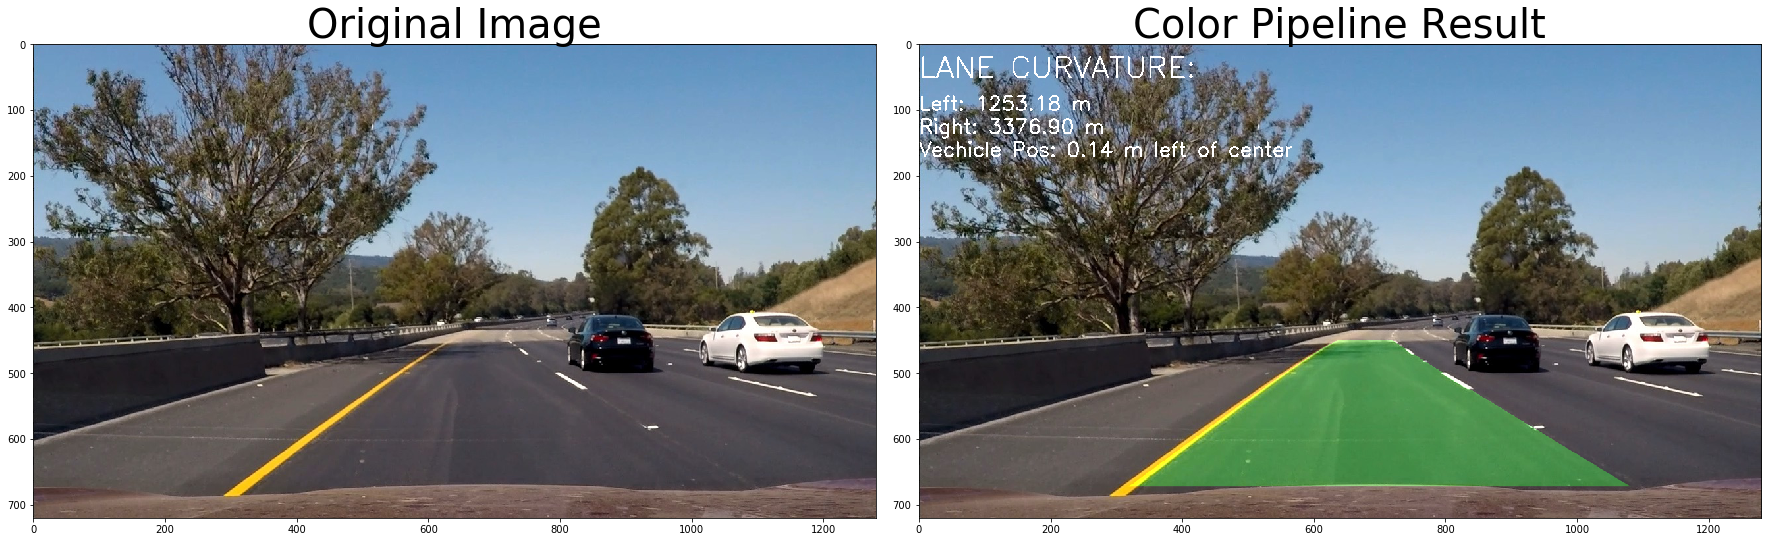

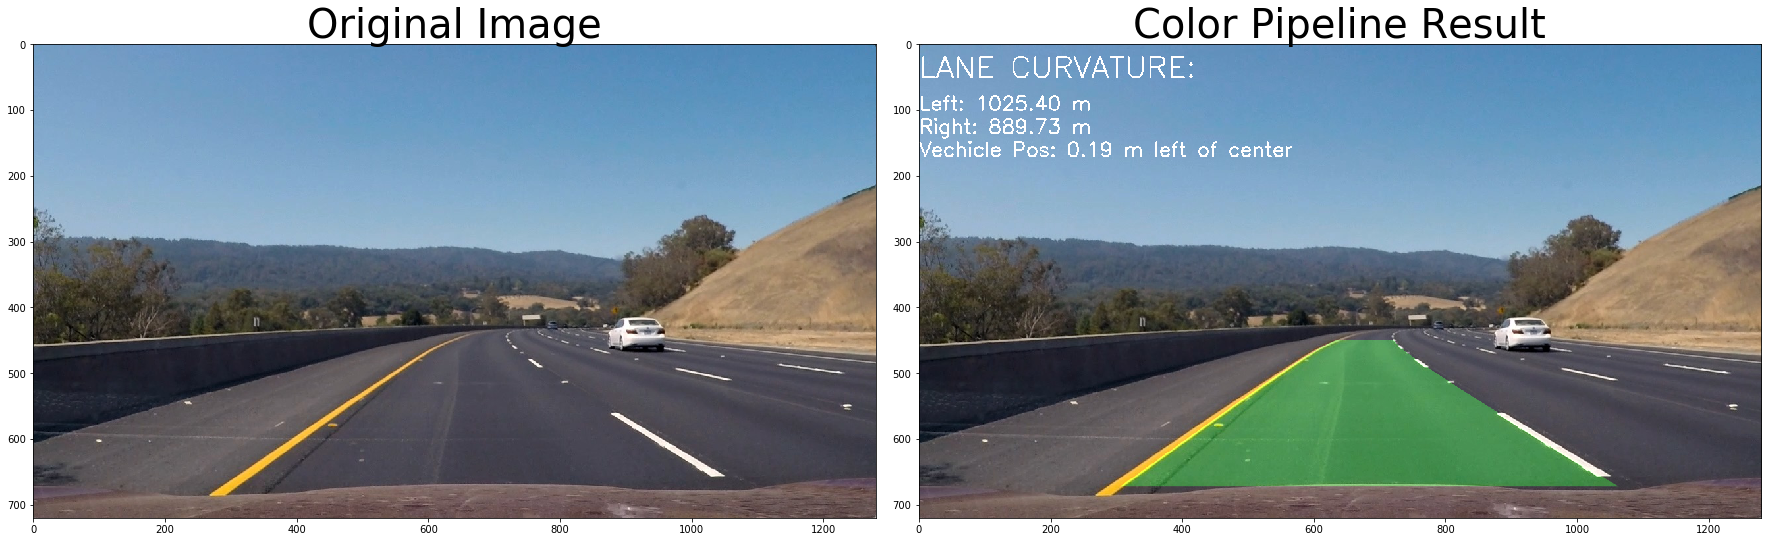

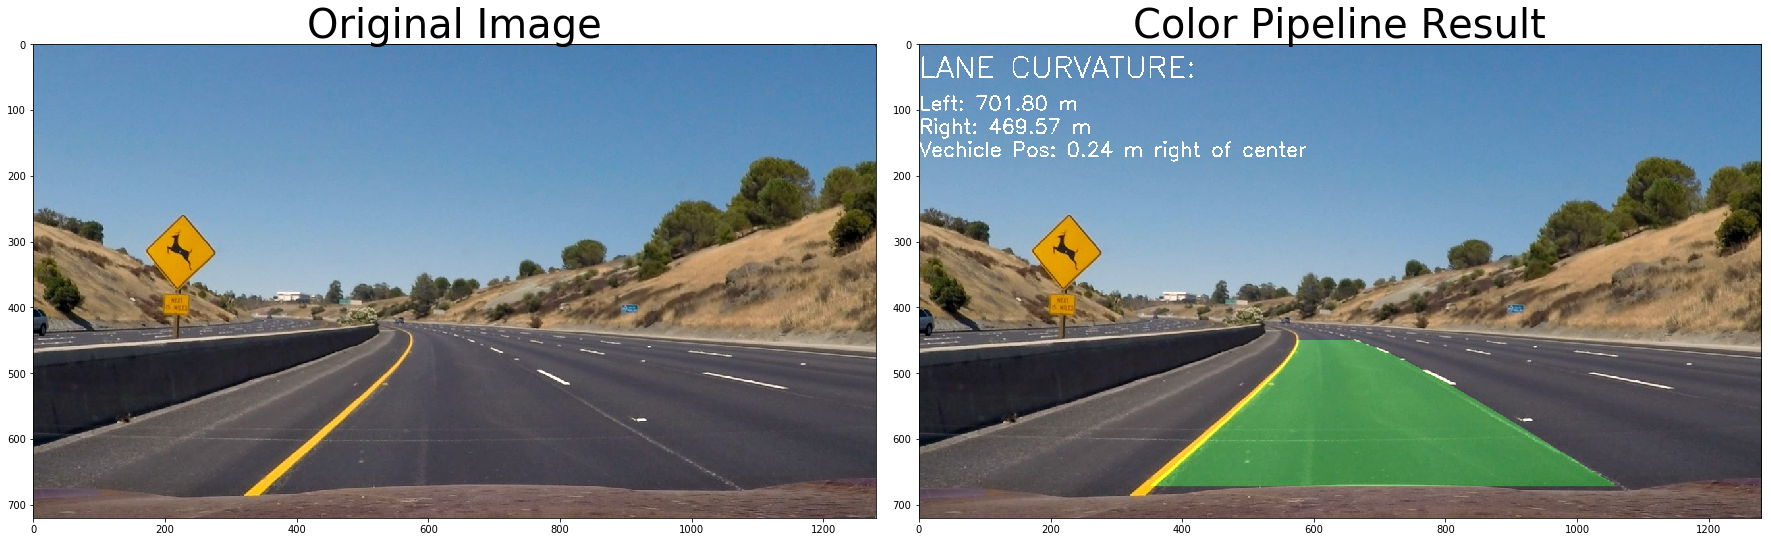

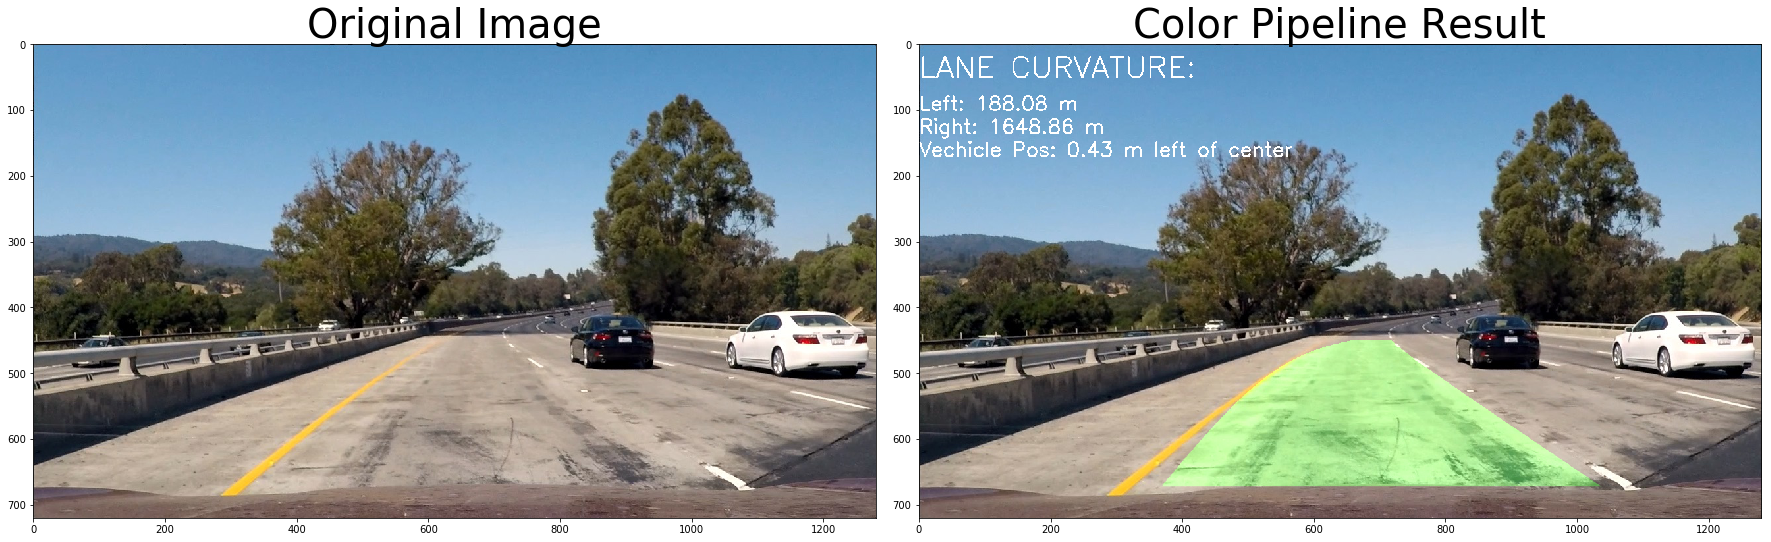

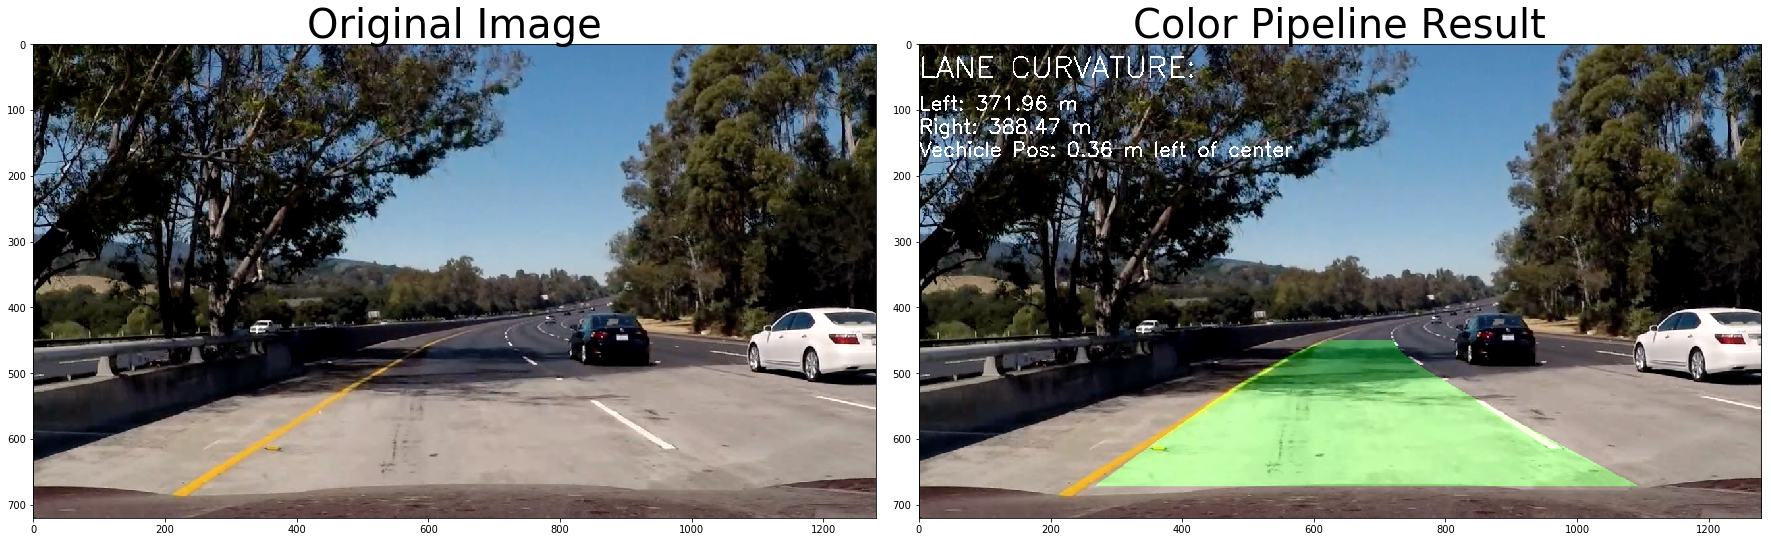

In [212]:
for filename in test_images_names:
    
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    final = pipeline(image)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(final)
    ax2.set_title('Color Pipeline Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [213]:
def process_image(image):
    
    return pipeline(image)

In [214]:
project_output = 'output_images/debug.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_images/debug.mp4
[MoviePy] Writing video output_images/debug.mp4


 99%|█████████▉| 125/126 [00:28<00:00,  6.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/debug.mp4 

CPU times: user 2min 51s, sys: 3.51 s, total: 2min 54s
Wall time: 30.1 s
